In [5]:
# Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('logistic_regression_docs').getOrCreate()

# If you're getting an error with numpy, please type 'sudo pip install numpy --user' into the EC2 console.
from pyspark.ml.classification import LogisticRegression

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/10/03 08:52:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
# Use Spark to read in the Ecommerce Customers csv file. You can infer csv schemas. 
df = (spark.read
      .option("multiline", "true")
      .option("quote", '"')
      .option("header", "true")
      .option("escape", "\\")
      .option("escape", '"')
      .csv('data_unprocessed_2017_2018.csv')
)

In [7]:
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- age: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- country_live: string (nullable = true)
 |-- country_work: string (nullable = true)
 |-- race: string (nullable = true)
 |-- self_employed: string (nullable = true)
 |-- num_employees: string (nullable = true)
 |-- tech_company: string (nullable = true)
 |-- tech_role: string (nullable = true)
 |-- benefits: string (nullable = true)
 |-- care_options: string (nullable = true)
 |-- wellness_program: string (nullable = true)
 |-- seek_help_resources: string (nullable = true)
 |-- anonymity: string (nullable = true)
 |-- leave_difficulty: string (nullable = true)
 |-- phys_vs_mental: string (nullable = true)
 |-- supervisor_willingness: string (nullable = true)
 |-- supervisor_experience: string (nullable = true)
 |-- supervisor_description: string (nullable = true)
 |-- coworkers_willingness: string (nullable = true)
 |-- coworkers_experience: string (nullable = true)
 |-- 

In [8]:
df.head()

22/10/03 08:52:23 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Row(ID='0', age='27', gender='Female', country_live='United Kingdom', country_work='United Kingdom', race='I prefer not to answer', self_employed='0', num_employees='100-500', tech_company='1', tech_role='1', benefits='No', care_options='Yes', wellness_program='No', seek_help_resources="I don't know", anonymity="I don't know", leave_difficulty="I don't know", phys_vs_mental='Same level of comfort for each', supervisor_willingness='Yes', supervisor_experience='0', supervisor_description=None, coworkers_willingness='Yes', coworkers_experience='1', coworkers_description='Spoke about my anxiety they were very supportive', phys_health_importance='6', mental_health_importance='0', mental_health_coverage=None, tell_others_experience=None, tell_others_consequence=None, scope_productivity=None, prev_employer='1', prev_tech_company='0', prev_benefits="I don't know", prev_care_options='N/A (was not aware)', prev_wellness_program='Some did', prev_seek_help_resources='Some did', prev_anonymity='Yes

In [9]:
for item in df.head():
    print(item)

0
27
Female
United Kingdom
United Kingdom
I prefer not to answer
0
100-500
1
1
No
Yes
No
I don't know
I don't know
I don't know
Same level of comfort for each
Yes
0
None
Yes
1
Spoke about my anxiety they were very supportive
6
0
None
None
None
None
1
0
I don't know
N/A (was not aware)
Some did
Some did
Yes, always
Physical health
Yes, all of my previous supervisors
0
None
No, at none of my previous employers
0
None
3
3
Possibly
None
Possibly
1
No
Sometimes
No
5
Yes
None
No
I'd be worried they wouldn't hire me 
0
10
Yes, I experienced
None
Yes, I experienced
None
1


In [10]:
from pyspark.sql.functions import col, avg
df.select(avg('age')).collect()

[Row(avg(age)=35.375)]

In [11]:
df.select('gender').distinct().collect()

[Row(gender='female (cisgender)'),
 Row(gender='femalw'),
 Row(gender='Cis-Female'),
 Row(gender='transgender'),
 Row(gender='cis-male'),
 Row(gender='genderfluid'),
 Row(gender='My sex is female.'),
 Row(gender='non-binary'),
 Row(gender='F'),
 Row(gender='None'),
 Row(gender='Genderqueer'),
 Row(gender='Demiguy'),
 Row(gender='God King of the Valajar'),
 Row(gender='man'),
 Row(gender='none'),
 Row(gender='Man'),
 Row(gender='gender non-conforming woman'),
 Row(gender='Cis male'),
 Row(gender='Female '),
 Row(gender='m'),
 Row(gender=None),
 Row(gender='Agender'),
 Row(gender='Male (cis)'),
 Row(gender='f'),
 Row(gender='dude'),
 Row(gender='woman'),
 Row(gender='Cis woman'),
 Row(gender='Female'),
 Row(gender='Cisgender male'),
 Row(gender='Cis female '),
 Row(gender='Male (or female, or both)'),
 Row(gender='cis-Female'),
 Row(gender='female'),
 Row(gender='Agender/genderfluid'),
 Row(gender='trans woman'),
 Row(gender='M'),
 Row(gender='SWM'),
 Row(gender='Woman-identified'),
 Row

In [12]:
df.select('unsupportive_description').distinct().collect()

[Row(unsupportive_description='Mostly burn outs totaly unhandled by hierarchy or hr.'),
 Row(unsupportive_description='Previous job worked me for 60+ days in a row until I had a mental breakdown to which I got told to "suck it up and deal with it" or else I would be fired.'),
 Row(unsupportive_description='Coworker transitioned mtf and was treated poorly by coworkers and management'),
 Row(unsupportive_description='Too many to list.'),
 Row(unsupportive_description='Addiction and how it was handled'),
 Row(unsupportive_description='To pick one example, treating anxiety and depression as "not our problem, get your work done"'),
 Row(unsupportive_description='A former colleague at a former position was having severe issues that may have been anxiety or depression.  My boss was not supportive at all and my teammates and I did not know what to do other than try to be supportive and refer him to EAP.  He ended up having an episode at work that led to him being put on medical leave and event

In [13]:
print((df.count(), len(df.columns)))

(1178, 64)


In [14]:
null_count = {col:df.filter(df[col].isNull()).count() for col in df.columns}
null_count

{'ID': 0,
 'age': 2,
 'gender': 16,
 'country_live': 2,
 'country_work': 2,
 'race': 0,
 'self_employed': 0,
 'num_employees': 169,
 'tech_company': 169,
 'tech_role': 169,
 'benefits': 169,
 'care_options': 273,
 'wellness_program': 169,
 'seek_help_resources': 169,
 'anonymity': 169,
 'leave_difficulty': 169,
 'phys_vs_mental': 169,
 'supervisor_willingness': 169,
 'supervisor_experience': 169,
 'supervisor_description': 909,
 'coworkers_willingness': 169,
 'coworkers_experience': 170,
 'coworkers_description': 844,
 'phys_health_importance': 169,
 'mental_health_importance': 169,
 'mental_health_coverage': 1009,
 'tell_others_experience': 1009,
 'tell_others_consequence': 1009,
 'scope_productivity': 1009,
 'prev_employer': 0,
 'prev_tech_company': 143,
 'prev_benefits': 143,
 'prev_care_options': 143,
 'prev_wellness_program': 143,
 'prev_seek_help_resources': 143,
 'prev_anonymity': 143,
 'prev_phys_vs_mental': 143,
 'prev_supervisor_willingness': 143,
 'prev_supervisor_experience

## 2.2 Data Exploration

In [15]:
from pyspark.sql.functions import *
from pyspark import SparkContext
from pyspark.sql import SQLContext
from functools import reduce
import pyspark.sql.functions as F
import pandas as pd
import numpy as np
summary = df.describe().filter("summary = 'count'")
columns = df.columns
counts  = df.count()

summary.rdd \
  .flatMap(lambda row: map(lambda i: (columns[i-1], row[i]), range(1, len(row)))) \
  .toDF(['column', 'count']) \
  .withColumn('not_null_ratio', col('count') / counts * 100) \
.sort(desc("not_null_ratio"))\
  .show(100, False)



+-----------------------------+-----+------------------+
|column                       |count|not_null_ratio    |
+-----------------------------+-----+------------------+
|race                         |1178 |100.0             |
|prev_employer                |1178 |100.0             |
|friends_fam_willingness      |1178 |100.0             |
|phys_interview               |1178 |100.0             |
|mh_disorder                  |1178 |100.0             |
|mental_interview             |1178 |100.0             |
|mh_treatment                 |1178 |100.0             |
|ID                           |1178 |100.0             |
|self_employed                |1178 |100.0             |
|mh_family_history            |1178 |100.0             |
|work_interfere_treated       |1178 |100.0             |
|witness_unsupportive         |1176 |99.830220713073   |
|witness_supportive           |1176 |99.830220713073   |
|tech_ind_support             |1176 |99.830220713073   |
|team_reaction                |

In [16]:
from pyspark.sql.types import IntegerType
df = df.withColumn("age", df["age"].cast(IntegerType()))

#data_df = df.withColumn("age", data_df["age"].cast(IntegerType()))

In [17]:
df.describe('age').show()

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|              1176|
|   mean|            35.375|
| stddev|10.366542951531986|
|    min|                18|
|    max|               139|
+-------+------------------+



## 2.3 Exploratory data analysis

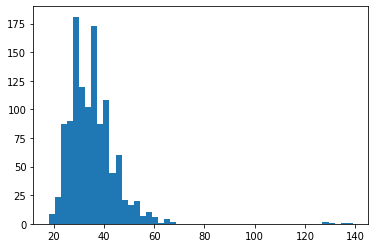

In [18]:
# Import the relevant Python libraries.
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


age = np.array(df.filter('age > 0').select('age').collect())
plt.hist(age, bins =50)
plt.show()

In [19]:
df_filter1 = df.filter('age < 100')
print((df_filter1.count(), len(df_filter1.columns)))

(1171, 64)


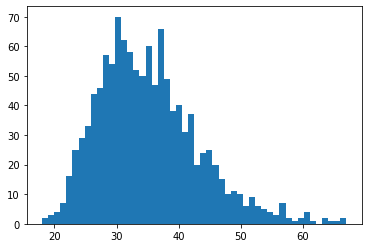

In [20]:
age = np.array(df_filter1.select('age').collect())
plt.hist(age, bins =50)
plt.show()

In [33]:
df_filter1 =  df_filter1.withColumn("gender",F.lower(F.col("gender")))

df_filter1.select('gender').distinct().collect()

[Row(gender='female (cisgender)'),
 Row(gender='femalw'),
 Row(gender='transgender'),
 Row(gender='female (cis) '),
 Row(gender='nb'),
 Row(gender='cis-male'),
 Row(gender='genderfluid'),
 Row(gender='non-binary'),
 Row(gender='female-ish'),
 Row(gender='she/her/they/them'),
 Row(gender='woman-identified'),
 Row(gender='genderqueer demigirl'),
 Row(gender='man'),
 Row(gender='none'),
 Row(gender='gender non-conforming woman'),
 Row(gender='genderqueer'),
 Row(gender='m'),
 Row(gender='transfeminine'),
 Row(gender=None),
 Row(gender='male, cis'),
 Row(gender='malel'),
 Row(gender='f'),
 Row(gender='trans female'),
 Row(gender='dude'),
 Row(gender='woman'),
 Row(gender='cisgendered woman'),
 Row(gender='female'),
 Row(gender='trans woman'),
 Row(gender='other'),
 Row(gender='non binary'),
 Row(gender='agender/genderfluid'),
 Row(gender='male-ish'),
 Row(gender='male '),
 Row(gender='cis female '),
 Row(gender='femail'),
 Row(gender='i identify as female'),
 Row(gender='cis hetero male'),

In [36]:
df_filter1.select('gender').distinct().collect()

[Row(gender='female (cisgender)'),
 Row(gender='femalw'),
 Row(gender='transgender'),
 Row(gender='female (cis) '),
 Row(gender='nb'),
 Row(gender='cis-male'),
 Row(gender='genderfluid'),
 Row(gender='non-binary'),
 Row(gender='female-ish'),
 Row(gender='she/her/they/them'),
 Row(gender='woman-identified'),
 Row(gender='genderqueer demigirl'),
 Row(gender='man'),
 Row(gender='none'),
 Row(gender='gender non-conforming woman'),
 Row(gender='genderqueer'),
 Row(gender='m'),
 Row(gender='transfeminine'),
 Row(gender=None),
 Row(gender='male, cis'),
 Row(gender='malel'),
 Row(gender='f'),
 Row(gender='trans female'),
 Row(gender='dude'),
 Row(gender='woman'),
 Row(gender='cisgendered woman'),
 Row(gender='female'),
 Row(gender='trans woman'),
 Row(gender='other'),
 Row(gender='non binary'),
 Row(gender='agender/genderfluid'),
 Row(gender='male-ish'),
 Row(gender='male '),
 Row(gender='cis female '),
 Row(gender='femail'),
 Row(gender='i identify as female'),
 Row(gender='cis hetero male'),

In [22]:
from pyspark.sql.functions import col, countDistinct

df_filter1.select(F.countDistinct("gender")).show()

+----------------------+
|count(DISTINCT gender)|
+----------------------+
|                    87|
+----------------------+



In [45]:
import pyspark.sql.functions as F

df_filter1 =  df_filter1.withColumn("gender",F.lower(F.col("gender")))

female_list = ['female', 'f','female ', 'femalw', 'femail', 'female (cis)', 'female (cis) ','cis female ',
                            'my sex is female.', 'female (cisgender)', 'woman-identified', 'cis-female', 
                            'cis female', 'f, cisgender', 'female-ish', 'trans woman', 'i identify as female',
                            '*shrug emoji* (f)', 'cis woman', 'cisgendered woman', 'trans female', 'woman',
                            'cisgender female']

male_list = ['m', 'man', 'cis-male', 'mail', 'male/androgynous ','cis hetero male', 
                            'male (cis)','male (hey this is the tech industry you\'re talking about)',
                            'god king of the valajar', 'cis male', 'male ', 'male, cis', 'cis male ',
                            'male-ish','dude','ostensibly male','male, born with xy chromosoms','malel', 
                            'trans man','cisgender male', 'swm', 'male']

from pyspark.sql.functions import when

df_filter1 = df_filter1.withColumn('gender_new',
                                    when(col('gender').isin(female_list),'female')\
                                   .when(col('gender').isin(male_list),'male')\
                                   .otherwise('non-binary'))



In [46]:
df_filter1.groupBy('gender_new').count().show()

+----------+-----+
|gender_new|count|
+----------+-----+
|non-binary|   49|
|    female|  348|
|      male|  774|
+----------+-----+



In [48]:
df_male_mh = df_filter1.where(F.col('gender_new')=='male')

df_male_mh.groupBy('mh_treatment').count().show()

+------------+-----+
|mh_treatment|count|
+------------+-----+
|           0|  352|
|           1|  422|
+------------+-----+



In [50]:
df_female_mh = df_filter1.where(F.col('gender_new')=='female')

df_female_mh.groupBy('mh_treatment').count().show()

+------------+-----+
|mh_treatment|count|
+------------+-----+
|           0|   91|
|           1|  257|
+------------+-----+



<AxesSubplot:xlabel='gender_new'>

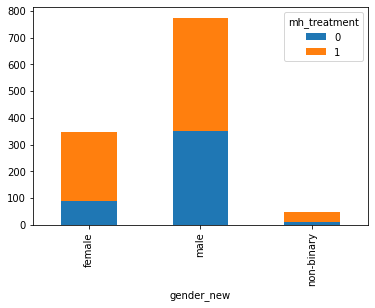

In [60]:
df_gender = df_filter1.groupby('mh_treatment','gender_new').count()
pdf_1 = df_gender.toPandas()
pdf_1.pivot( 'gender_new', 'mh_treatment','count').plot.bar(stacked=True)

In [55]:
df_family = df_filter1.groupby('mh_treatment','mh_family_history').count()
df_family.show()

+------------+-----------------+-----+
|mh_treatment|mh_family_history|count|
+------------+-----------------+-----+
|           0|     I don't know|  104|
|           1|               No|  109|
|           0|               No|  229|
|           1|     I don't know|  184|
|           1|              Yes|  424|
|           0|              Yes|  121|
+------------+-----------------+-----+



In [56]:
pdf_1 = df_family.toPandas()

<AxesSubplot:xlabel='mh_family_history'>

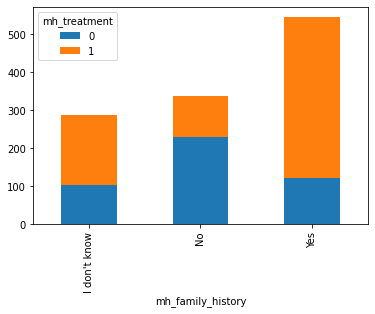

In [59]:
pdf_1.pivot( 'mh_family_history', 'mh_treatment','count').plot.bar(stacked=True)

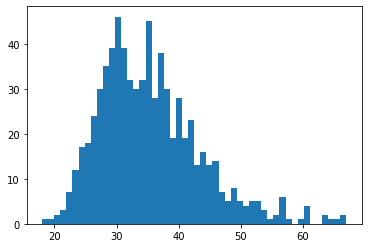

In [130]:
age_1 = np.array(df_filter1.filter('mh_treatment == 1').select('age').collect())
plt.hist(age_1, bins =50)
plt.show()

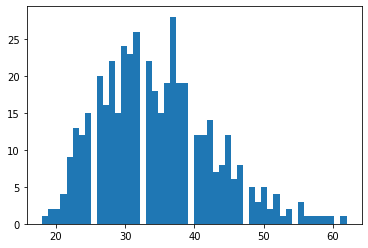

In [132]:
age_2 = np.array(df_filter1.filter('mh_treatment == 0').select('age').collect())
plt.hist(age_2, bins =50)
plt.show()

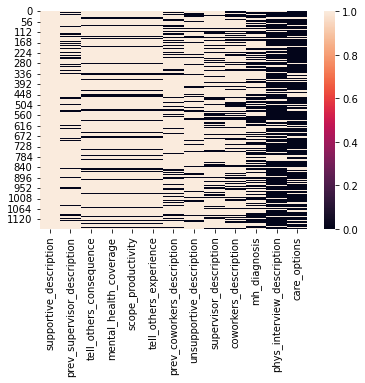

In [74]:
#checking missing values:
missing_check_cols = ['supportive_description' , 'prev_supervisor_description', 'tell_others_consequence', 'mental_health_coverage','scope_productivity','tell_others_experience',        
'prev_coworkers_description','unsupportive_description','supervisor_description','coworkers_description','mh_diagnosis','phys_interview_description', 'care_options'] 
df_missing_high = df_filter1.select(*missing_check_cols)
plot_df = df_missing_high.toPandas()
sns.heatmap(data = plot_df.isna())  

In [80]:
#remove the columns with more than 70% missing values:
remove_cols_70_missing = ['supportive_description' , 'prev_supervisor_description', 'tell_others_consequence', 'mental_health_coverage','scope_productivity','tell_others_experience',        
'prev_coworkers_description','unsupportive_description','supervisor_description','coworkers_description']
df_filter1 = df_filter1.drop(*remove_cols_70_missing)
print((df_filter1.count(), len(df_filter1.columns)))

(1171, 59)
